In [145]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from evaluation import compute_rmse

import scipy.io as sio
import numpy as np
import os
import math
import time
import random
seed = 1
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [ ]:
path='generated HSI/'
files=os.listdir(path)
dataset=[]
abundances=[]
for file in files:
    fname  = path+file
    mat = scipy.io.loadmat(fname2)
    A = mat["A"]
    Y = mat["Y"]
    abundances.append(A)
    dataset.append(Y)
dataset=np.array(dataset)

In [147]:
P, L, col = 5, dataset.shape[-1], dataset.shape[1]
LR, EPOCH, batch_size = 2e-3, 480, 1
beta, delta, gamma = 0.5, 1e-3, 1e-7
sparse_decay, weight_decay_param = 5e-6, 1e-4
index = [1,2,0]

In [148]:
Y = torch.tensor(dataset)
Y=Y.permute(0, 3, 1, 2)

In [153]:
import torch
from torch.utils.data import Dataset, DataLoader

In [154]:
class MyTrainData(Dataset):
    def __init__(self, img, transform=None):
        self.img = img  # input images
        self.transform = transform

    def __getitem__(self, idx):
        image = self.img[idx]  
        if self.transform:
            image = self.transform(image)  # apply transformation if provided
        return image

    def __len__(self):
        return len(self.img)
dataset= MyTrainData(img=Y)


In [157]:
import torch
from torch.utils.data import random_split, DataLoader


dataset = MyTrainData(img=Y)

# Proprtions for trainset, testset and validationset
train_size = int(0.8 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size


train_dataset=dataset[:train_size]
val_dataset=dataset[train_size:train_size+val_size]
test_dataset = dataset[:test_size]

# DataLoaders for each set
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")


Training set size: 76
Validation set size: 14
Test set size: 5


In [159]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
# Computes the nuclear norm of the input tensor
def Nuclear_norm(inputs):
    _, band, h, w = inputs.shape
    input = torch.reshape(inputs, (band, h*w))
    # Compute the nuclear norm (sum of singular values) of the reshaped tensor
    out = torch.norm(input, p='nuc')
    return out

# Defines loss function that encourages sparsity in the input tensor
class SparseKLloss(nn.Module):
    def __init__(self):
        super(SparseKLloss, self).__init__()

    def __call__(self, input, decay=sparse_decay):
        input = torch.sum(input, 0, keepdim=True)
        # Compute nuclear norm as the loss
        loss = Nuclear_norm(input)
        # Return the loss scaled by the decay factor
        return decay * loss

# clips weights to ensure they stay within a certain range
class NonZeroClipper(object):
    def __call__(self, module):
        # Check if the module has weights 
        if hasattr(module, 'weight'):
            w = module.weight.data
            # Clamp the weights to the range [1e-6, 1], setting any values below 1e-6 to 1e-6
            w.clamp_(1e-6, 1)


# Defines loss function that ensures the input sums to one
class SumToOneLoss(nn.Module):
    def __init__(self):
        super(SumToOneLoss, self).__init__()
        self.register_buffer('one', torch.tensor(1, dtype=torch.float))
        # Initialize the L1 loss (mean absolute error) function
        self.loss = nn.L1Loss(size_average=False)

    def get_target_tensor(self, input):
        target_tensor = self.one  
        return target_tensor.expand_as(input)

    # compute the SumToOne loss
    def __call__(self, input, gamma_reg=gamma):
        input = torch.sum(input, 1)
        # Generate the target tensor which is 1 for each element
        target_tensor = self.get_target_tensor(input)
        # Calculate the L1 loss between the summed input and the target (which is 1)
        loss = self.loss(input, target_tensor)
        # Return the loss scaled by the regularization factor gamma
        return gamma_reg * loss


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(L, 128,kernel_size=(1,1), stride=1, padding=(0,0)),
            nn.BatchNorm2d(128,momentum=0.9),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Conv2d(128, 64,kernel_size=(1,1), stride=1, padding=(0,0)),
            nn.BatchNorm2d(64,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(64, P, kernel_size=(1,1), stride=1, padding=(0,0)),
            nn.BatchNorm2d(P,momentum=0.9),
        )

        self.decoder1 = nn.Sequential(
            nn.Conv2d(P, L, kernel_size=1, stride=1, bias=False),
            nn.ReLU(),
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(P, L, kernel_size=1, stride=1, bias=False),
            nn.ReLU(),
        )
    def forward(self,x):
        abu_est1 = self.encoder(x).clamp_(0,1)
        re_result1 = self.decoder1(abu_est1)
        abu_est2 = self.encoder(re_result1).clamp_(0,1)
        re_result2 = self.decoder2(abu_est2)
        return abu_est1, re_result1, abu_est2, re_result2 , net.decoder1[0].weight, net.decoder2[0].weight

#Initialize weights of specific layers in the network
def weights_init(m):
    nn.init.kaiming_normal_(net.encoder[0].weight.data)
    nn.init.kaiming_normal_(net.encoder[4].weight.data)
    nn.init.kaiming_normal_(net.encoder[7].weight.data)



net=AutoEncoder()
net.apply(weights_init)
criterionSumToOne = SumToOneLoss()
criterionSparse = SparseKLloss()
train_losses=[]
train_losses_sumtoone=[]
train_losses_sparse=[]
train_losses_re=[]
train_losses_abu=[]

val_losses=[]
val_losses_sumtoone=[]
val_losses_sparse=[]
val_losses_re=[]
val_losses_abu=[]

model_dict = net.state_dict()
net.load_state_dict(model_dict)

loss_func = nn.MSELoss(size_average=True,reduce=True,reduction='mean')
#Define the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=weight_decay_param)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
apply_clamp_inst1 = NonZeroClipper()

time_start = time.time()
for epoch in range(EPOCH):
    for i, x in enumerate(train_loader):
        x = x.float()  
        net.train()
        abu_est1, re_result1, abu_est2, re_result2,w1,w2 = net(x)

        loss_sumtoone = criterionSumToOne(abu_est1) + criterionSumToOne(abu_est2)
        loss_sparse = criterionSparse(abu_est1) + criterionSparse(abu_est2)
        loss_re = beta*loss_func(re_result1,x) + (1-beta)*loss_func(x,re_result2)
        loss_abu = delta*loss_func(abu_est1,abu_est2)

        total_loss =loss_re+loss_abu+loss_sumtoone+loss_sparse
        train_losses_sumtoone.append(loss_sumtoone)
        train_losses_sparse.append(loss_sparse)
        train_losses_re.append(loss_re)
        train_losses_abu.append(loss_abu)
        train_losses.append(total_loss)
        optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=10, norm_type=1)
        optimizer.step()

        net.decoder1.apply(apply_clamp_inst1)
        net.decoder2.apply(apply_clamp_inst1)

        if epoch % 10 == 0:
            print('Epoch:', epoch, '| i:', i,'| train loss: %.4f' % total_loss.data.numpy(),'| abu loss: %.4f' % loss_abu.data.numpy(),'| sumtoone loss: %.4f' % loss_sumtoone.data.numpy(),'| re loss: %.4f' % loss_re.data.numpy())
        net.eval()  # Mode évaluation
    val_loss = 0
    
    with torch.no_grad():  # Pas de calcul de gradients
        for i, x in enumerate(val_loader):
            x = x.float()
            abu_est1, re_result1, abu_est2, re_result2, w1, w2 = net(x)

            # Loss for validation set
            loss_sumtoone = criterionSumToOne(abu_est1) + criterionSumToOne(abu_est2)
            loss_sparse = criterionSparse(abu_est1) + criterionSparse(abu_est2)
            loss_re = beta * loss_func(re_result1, x) + (1 - beta) * loss_func(x, re_result2)
            loss_abu = delta * loss_func(abu_est1, abu_est2)

            total_loss = loss_re + loss_abu + loss_sumtoone + loss_sparse
            val_loss += total_loss.item()
            val_losses_sumtoone.append(loss_sumtoone)
            val_losses_sparse.append(loss_sparse)
            val_losses_re.append(loss_re)
            val_losses_abu.append(loss_abu)
            val_losses.append(total_loss)

        # Mean of validation loss
        val_loss /= len(val_loader)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Validation Loss: {val_loss:.4f}")
        
    scheduler.step()
time_end = time.time()

 


In [27]:
train_losses=[l.detach().numpy() for l in train_losses]

In [29]:
train_losses_sparse=[l.detach().numpy() for l in train_losses_sparse]
train_losses_re=[l.detach().numpy() for l in train_losses_re]
train_losses_abu=[l.detach().numpy() for l in train_losses_abu]
train_losses_sumtoone=[l.detach().numpy() for l in train_losses_sumtoone]

In [31]:
val_losses_sparse=[l.detach().numpy() for l in val_losses_sparse]
val_losses_re=[l.detach().numpy() for l in val_losses_re]
val_losses_abu=[l.detach().numpy() for l in val_losses_abu]
val_losses_sumtoone=[l.detach().numpy() for l in val_losses_sumtoone]

In [47]:


train_losses_sparse = np.array(train_losses_sparse)
train_losses_sparse_avg = np.mean(train_losses_sparse.reshape(-1, 5), axis=1)
train_losses_sparse_avg = train_losses_sparse_avg.tolist()

train_losses_re = np.array(train_losses_re)
train_losses_re_avg = np.mean(train_losses_re.reshape(-1, 5), axis=1)
train_losses_re_avg = train_losses_re_avg.tolist()

train_losses_abu = np.array(train_losses_abu)
train_losses_abu_avg = np.mean(train_losses_abu.reshape(-1, 5), axis=1)
train_losses_abu_avg = train_losses_abu_avg.tolist()

train_losses_sumtoone = np.array(train_losses_sumtoone)
train_losses_sumtoone_avg = np.mean(train_losses_sumtoone.reshape(-1, 5), axis=1)
train_losses_sumtoone_avg = train_losses_sumtoone_avg.tolist()

In [53]:
train_losses = np.array(train_losses)

train_losses_avg = np.mean(train_losses.reshape(-1, 5), axis=1)

train_losses_avg = train_losses_avg.tolist()

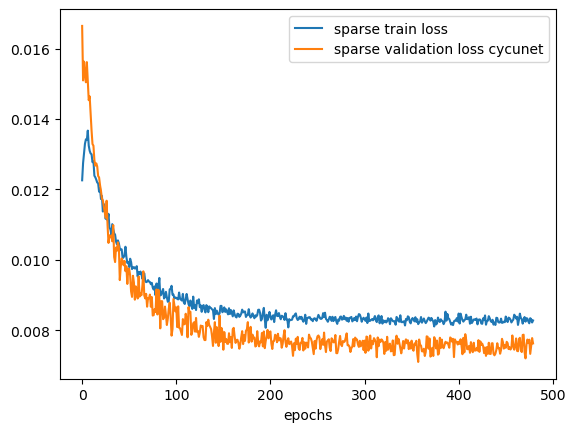

In [131]:
plt.plot(train_losses_sparse_avg,label='sparse train loss')
plt.plot(val_losses_sparse,label='sparse validation loss cycunet')
plt.xlabel('epochs')
plt.legend()
plt.show()

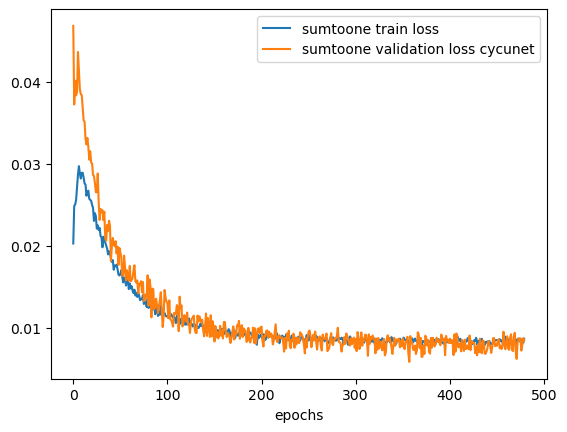

In [57]:
plt.plot(train_losses_sumtoone_avg,label='sumtoone train loss')
plt.plot(val_losses_sumtoone,label='sumtoone validation loss cycunet')
plt.xlabel('epochs')
plt.legend()
plt.show()

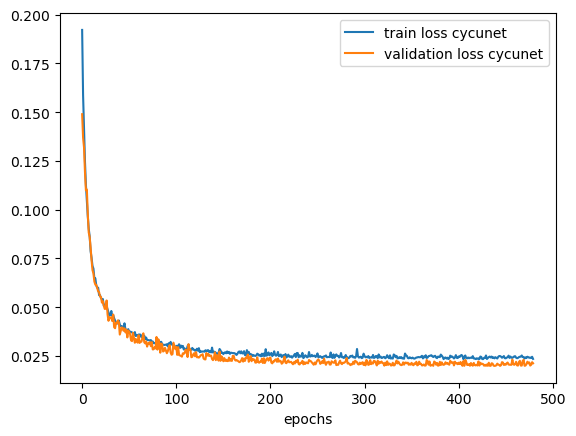

In [59]:
plt.plot(train_losses_avg,label='train loss cycunet')
plt.plot(val_losses,label='validation loss cycunet')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
ind=0

In [95]:
sample = test_loader.dataset[ind]
sample = sample.unsqueeze(0)
sample.shape

torch.Size([1, 113, 128, 128])

In [97]:
sample = sample.to(torch.float32)

In [99]:
net.eval()
abu_est1, re_result1, abu_est2, re_result2,w1,w2= net(sample)
abu_est1 = abu_est1/(torch.sum(abu_est1, dim=1))
abu_est1 = torch.reshape(abu_est1.squeeze(0),(P,col,col)).detach().numpy()

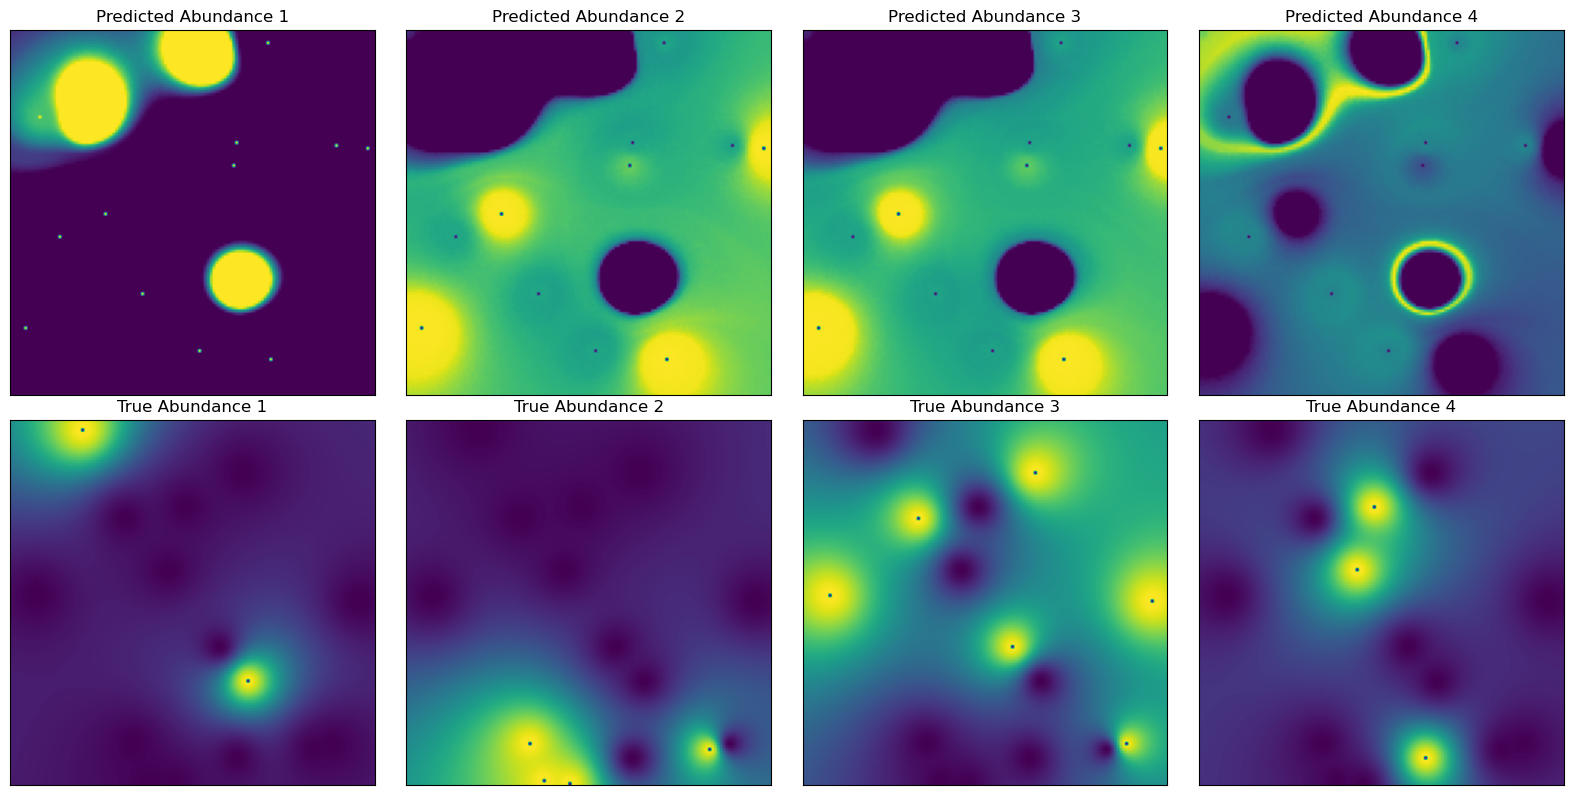

In [123]:

import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 4, figsize=(16, 8)) 

predicted_abundances=abu_est1.T
true_abundances=X_list[len(dataset)-len(test_loader)+ind]
for i in range(4):
    axes[0, i].imshow(predicted_abundances[:, :, i])
    axes[0, i].set_title(f"Predicted Abundance {i+1}")
    axes[0, i].set_xticks([])  
    axes[0, i].set_yticks([])


for i in range(4):
    axes[1, i].imshow(true_abundances[:, :, i])
    axes[1, i].set_title(f"True Abundance {i+1}")
    axes[1, i].set_xticks([])  
    axes[1, i].set_yticks([])


plt.tight_layout()
plt.savefig("heatmaps_10.png", dpi=300, bbox_inches='tight')
plt.show()

